In [10]:
def import_sam_data(memory_map=False, datapath='./census/UKDA-7207-tab/tab/01uklicsam-20070301.tab'):
    import pandas as pd
    if not memory_map: print('warning, reading a large table of 2964871 rows')
    return pd.read_table(datapath, memory_map=memory_map)

In [500]:
def import_la_dict(region='uk', datapath='./census/UKDA-7207-tab/tab/'):
    datapath += 'local_authorities_'+region+'.txt'
    with open(datapath, 'r') as fd:
        la = [x.strip() for x in fd.readlines()]
    return dict(zip(la, range(1, len(la)+1)))

In [2]:
sam_data = import_sam_data()

C:\Users\lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [553]:
sam_data.shape

(2964871, 88)

In [408]:
sam_data.head()

id  country  pnum  lacode  popbasea  acctypa  agea  bathwc  carsh  \
0  10009684        1  9684       1         0        3     0       1      0   
1  10009685        1  9685       1         0        3     0       1      1   
2  10009686        1  9686       1         0        3     0       1      1   
3  10009687        1  9687       1         0        3     0       1      0   
4  10009921        1  9921       1         0        2     0       1      2   

   cemtyp  ...    dfothurb  dftoturb  dflgmtwn  dfrutnp1  dfrutnp2  dfvilp  \
0      -9  ...         -98       -98       -98       -98       -98     -98   
1      -9  ...         -98       -98       -98       -98       -98     -98   
2      -9  ...         -98       -98       -98       -98       -98     -98   
3      -9  ...         -98       -98       -98       -98       -98     -98   
4      -9  ...         -98       -98       -98       -98       -98     -98   

   dfdisp  dftotrup  dftotr_1  defra  
0     -98       -98     -98.0    -98  
1     -98       -98     -98.0    -98  
2     -98       -98     -98.0    -98  
3     -98       -98     -98.0    -98  
4     -98       -98     -98.0    -98  

[5 rows x 88 columns]

In [511]:
la_dict = import_la_dict()

In [116]:
def import_map(datapath='./maps/', region='e'):
    """
    Returns a map object for the UK.
    
    Uses:
        1. pyshp (https://github.com/GeospatialPython/pyshp) for parsing ShapeFile
        2. shapely (https://shapely.readthedocs.io/en/latest/manual.html) for polygon object class
    """
    if region in ['e', 'w', 'l'] : datapath += 'Ew_groupedla_2011/ew_groupedla_2011'
    elif region=='s': datapath += 'Scotland_groupedla_2011/scotland_groupedca_2011'
    else: raise ValueError('valid regions are "l" (London), "e" (England), "w" (Wales) and "s" (Scotland)')
    from shapefile import Reader
    from shapely.geometry import Polygon
    sf = Reader(datapath+'.shp')
    polygons = dict()
    lab_dict = dict()
    for x in sf.shapeRecords():
        idx = x.record[0]
        name = x.record[1]
        lab_dict[name] = idx
        parts = list(x.shape.parts) + [len(x.shape.points)]
        polygons[idx] = (name, list())
        for i in range(len(parts)-1):
            polygons[idx][1].append(Polygon(x.shape.points[parts[i]:parts[i+1]]))
    return polygons, lab_dict

In [546]:
def draw_map(map_object, color=None, cmap='Paired', title=None, colorbar=False, ignore=False, size='l', label=False):
    """
    Plots a map object.
    
    Uses:
        1. shapely (https://shapely.readthedocs.io/en/latest/manual.html) for polygon object class
        2. descartes (https://pypi.org/project/descartes/) for plotting polygon objects
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from descartes.patch import PolygonPatch
    if color is None: color=12
    if isinstance(color, int):
        from random import randint
        color = [randint(1, color) for s in map_object]    
    if not isinstance(color, dict): color = dict(zip(map_object.keys(), color))
    norm = Normalize(vmin=min(color.values()), vmax=max(color.values()))
    if isinstance(cmap, str): cmap = plt.cm.get_cmap(cmap)
    size_dict = {'l':360, 'm':180, 's':90}
    fig = plt.figure(1, dpi=size_dict[size])
    ax = plt.subplot(1,1,1)
    for key, shape in map_object.items():
        if key in color or not ignore:
            lab_flag = label
            for s in shape[1]:
                x, y = s.exterior.xy
                ax.plot(x, y, alpha=0)
                if key in color: c = cmap(norm(color[key]))
                else: c = 'black'
                ax.add_patch(PolygonPatch(s, facecolor=c, edgecolor='black', linewidth=0.2, label=shape[0]))
                if lab_flag:
                    x_coord, y_coord = s.centroid.coords[0]
                    plt.text(x_coord, y_coord, str(shape[0]), ha='center', va='center', fontsize=4)
                    lab_flag = False
    if title is not None: ax.set_title(title)
    ax.set_aspect(1)
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        plt.colorbar(sm)
    plt.axis('off')
    plt.show()  

In [117]:
ew_gla_map, ew_gla_dict = import_map()

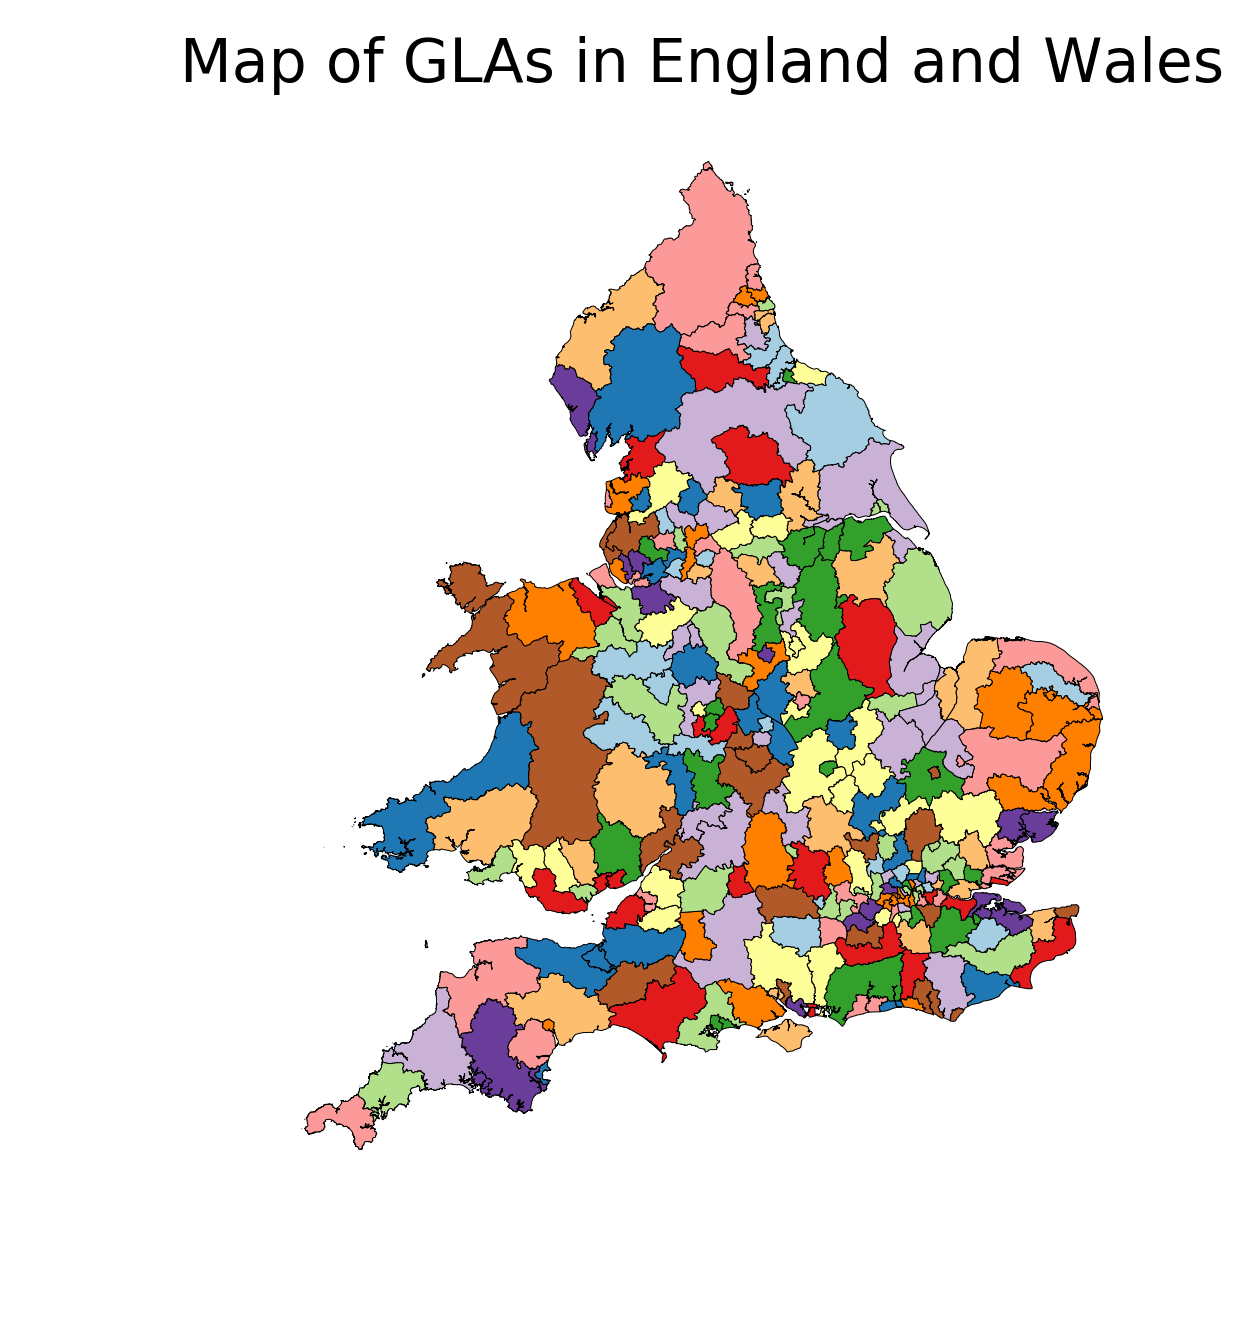

In [510]:
draw_map(ew_gla_map, title='Map of GLAs in England and Wales')

In [512]:
def la2gla(la_dict, gla_dict, verbose=False):
    la2gla_dict = dict()
    glas = list(gla_dict.keys())
    for key, val in la_dict.items():
        if key in glas: la2gla_dict[val] = gla_dict[key]
        else:
            found = False
            for gla in glas:
                if key in gla:
                    la2gla_dict[val] = gla_dict[gla]
                    found = True
                    break
            if not found and verbose: print('warning, no matching grouped-LA found for', key)
    return la2gla_dict

In [513]:
ew_la2gla_dict = la2gla(la_dict, ew_gla_dict)

In [516]:
def attribute_by_la(df, attribute, la2gla_dict=None, map_object=None, mean=False, ignore=[-9], ignore_missing=False, label=False):
    from numpy import nan
    df_oi = df[['lacode', attribute]].replace({attribute: dict(zip(ignore, [nan for i in ignore]))})
    df_oi = df_oi.groupby('lacode')[attribute]
    if mean: df_oi = df_oi.mean()
    else: df_oi = df_oi.value_counts()/df_oi.count() #normalized counts
    if la2gla_dict is not None and map_object is not None:
        def map_att(df_oi, title):
            colors = dict([(i, []) for i in map_object])
            for i in df_oi.index:
                if i in la2gla_dict: colors[la2gla_dict[i]].append(df_oi[i])
            for key in map_object:
                if colors[key]!=[]: colors[key] = sum(colors[key])/len(colors[key])
                else: del colors[key]
            draw_map(map_object, color=colors, cmap='Spectral', title=title, colorbar=True, ignore=ignore_missing, size='m', label=label)
            
        if mean: map_att(df_oi, title=attribute+' mean by GLA')
        else:
            for lab in df_oi.index.levels[1]:
                map_att(df_oi.loc[:,lab], title=attribute+' '+str(lab)+' by GLA')
    return df_oi

	Value = 1	Label = Male
	Value = 2	Label = Female

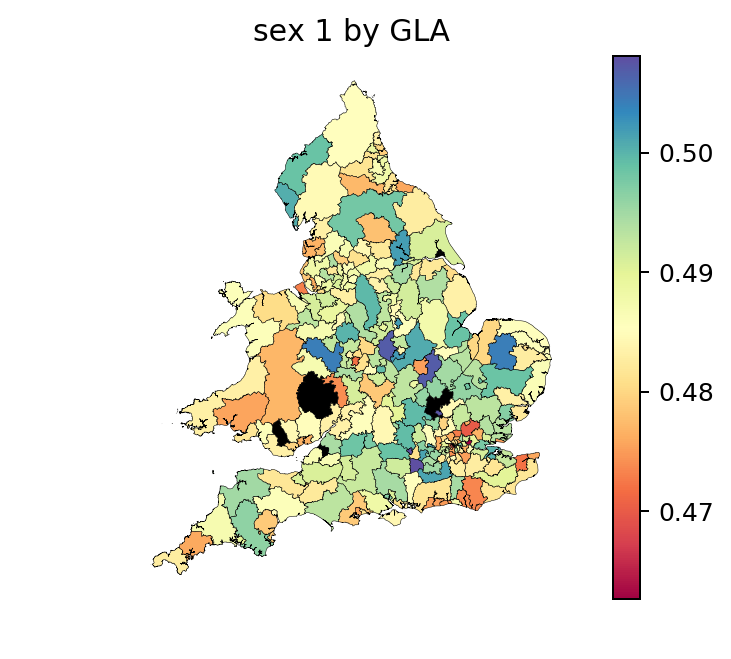

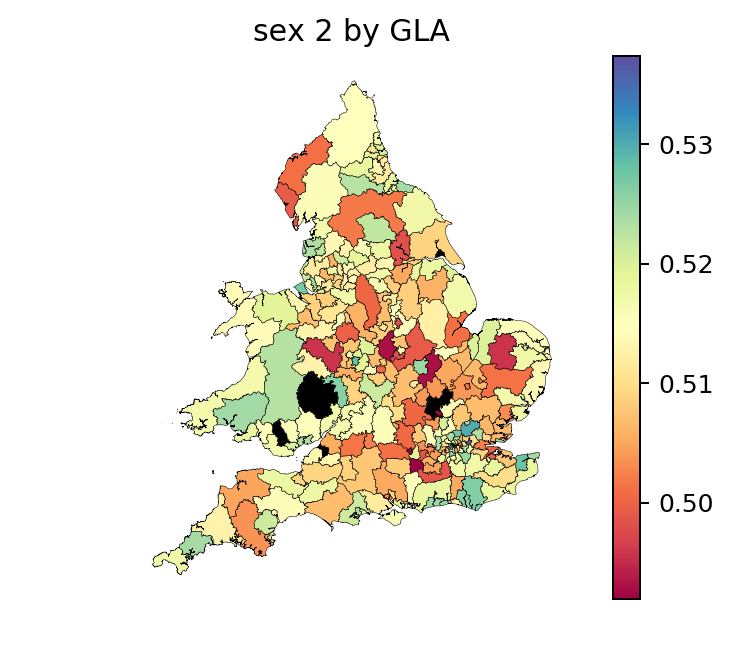

In [514]:
sex_by_la_ew = attribute_by_la(sam_data, 'sex', ew_la2gla_dict, ew_gla_map)

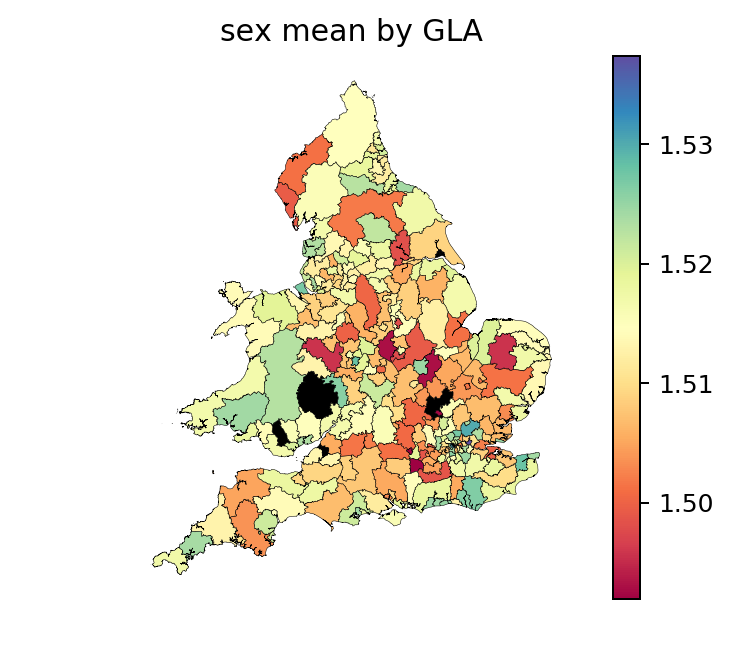

In [493]:
sex_by_la_ew_mean = attribute_by_la(sam_data, 'sex', ew_la2gla_dict, ew_gla_map, mean=True)

    Value = 1	Label = Good
	Value = 2	Label = Fairly good
	Value = 3	Label = Not good

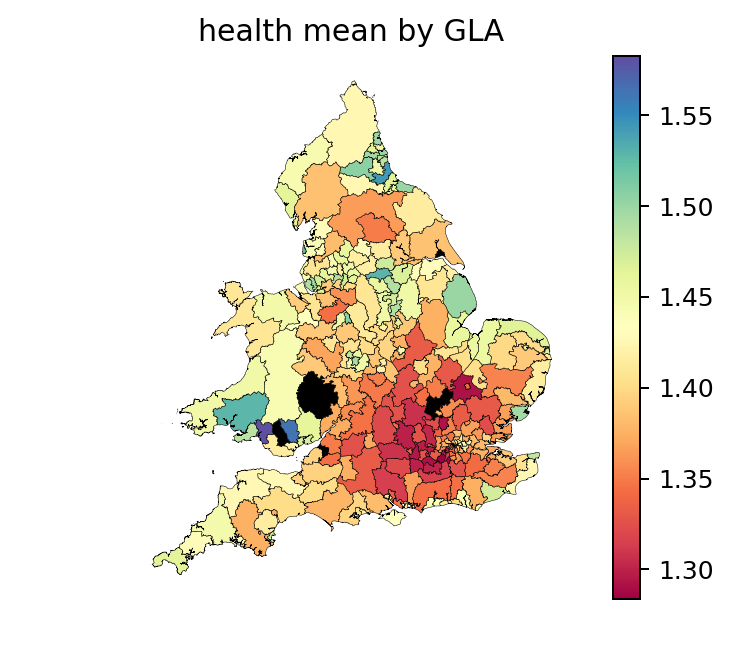

In [494]:
health_by_la_ew = attribute_by_la(sam_data, 'health', ew_la2gla_dict, ew_gla_map, mean=True)

    Value = 0	Label = 0-4
	Value = 5	Label = 5-9
	Value = 10	Label = 10-15
	Value = 16	Label = 16-19
	Value = 20	Label = 20-24
	Value = 25	Label = 25-29
	Value = 30	Label = 30-39
	Value = 40	Label = 40-49
	Value = 50	Label = 50-59
	Value = 60	Label = 60-64
	Value = 65	Label = 65-74
	Value = 75	Label = 75-84
	Value = 85	Label = 85+

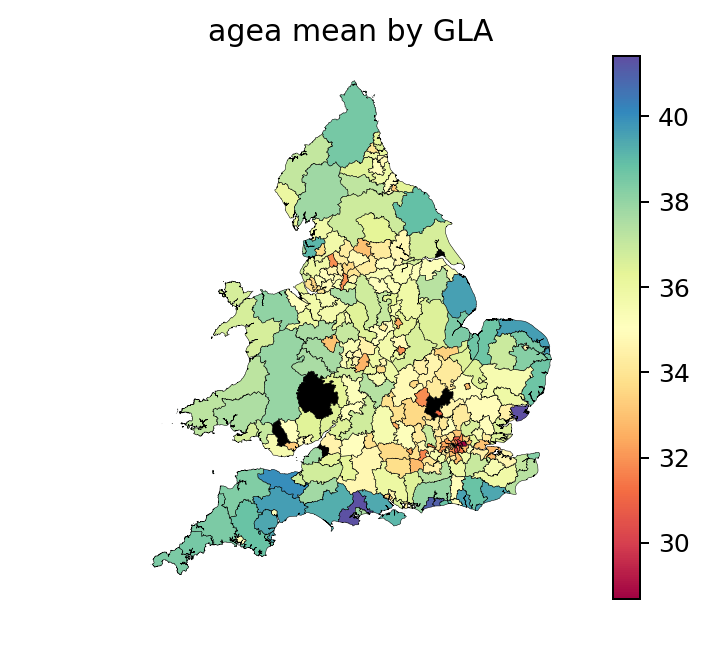

In [495]:
age_by_la_ew = attribute_by_la(sam_data, 'agea', ew_la2gla_dict, ew_gla_map, mean=True)

	Value = 1	Label = No qualifications
	Value = 2	Label = Level 1
	Value = 3	Label = Level 2
	Value = 4	Label = Level 3
	Value = 5	Label = Level 4/5

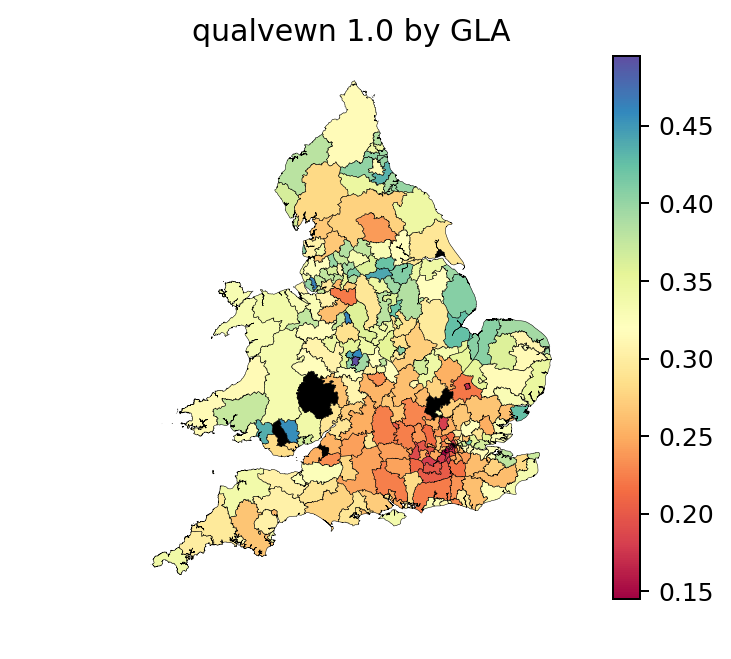

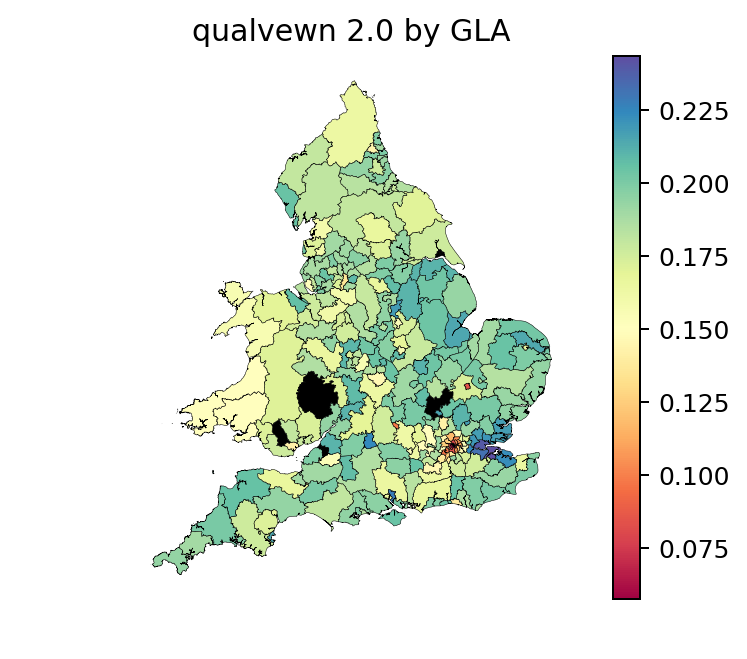

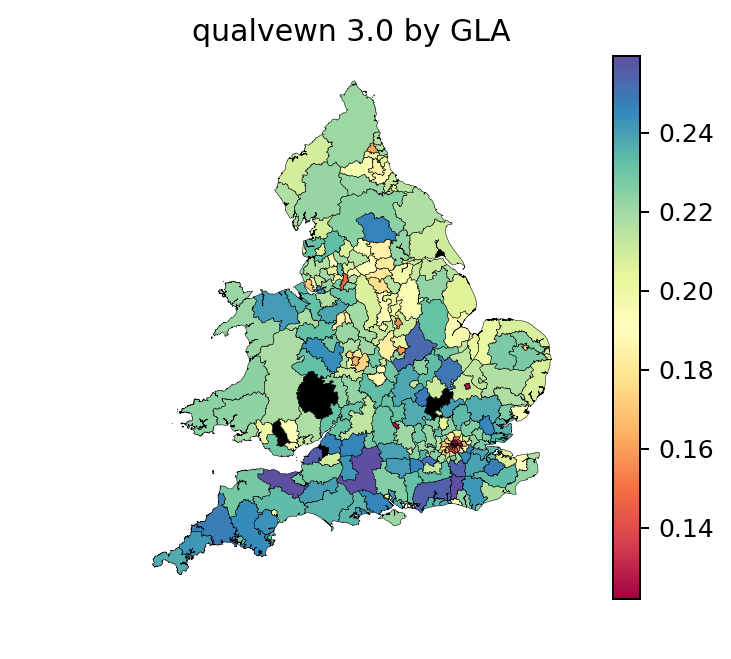

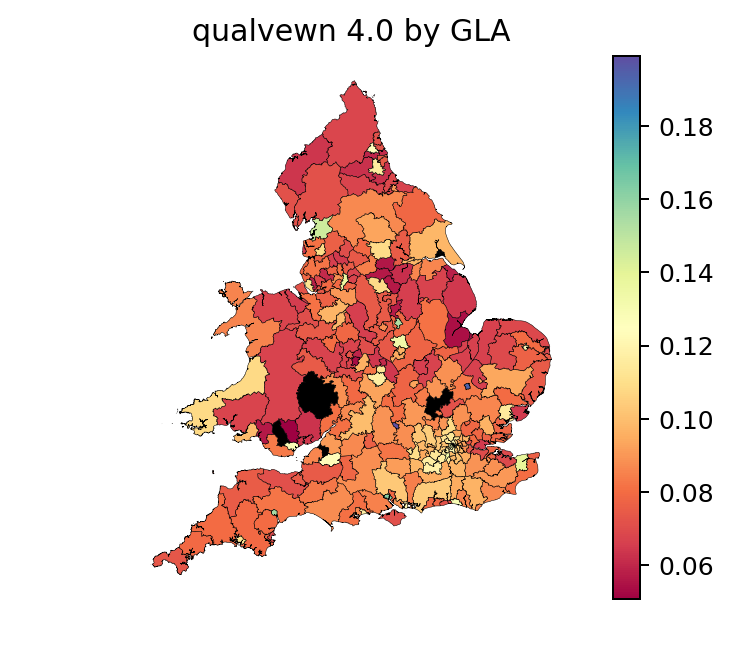

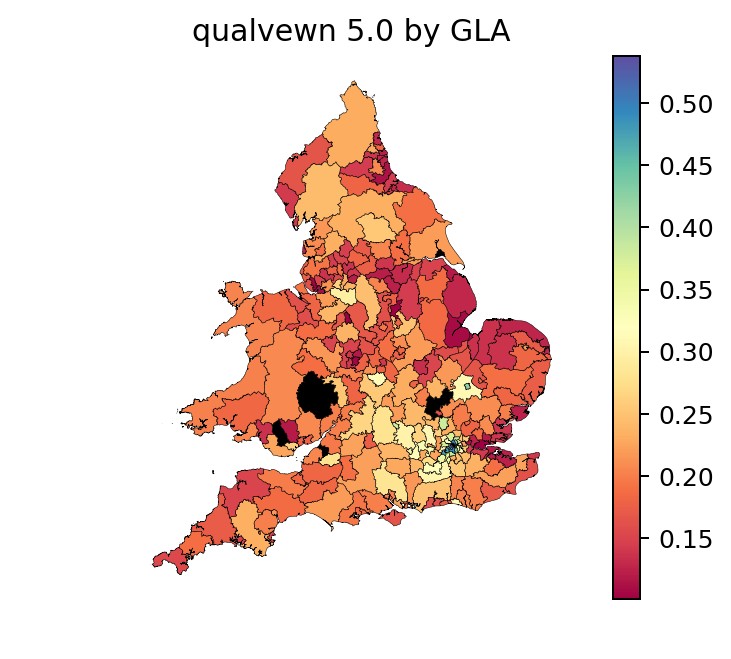

In [498]:
edu_by_la_ew = attribute_by_la(sam_data, 'qualvewn', ew_la2gla_dict, ew_gla_map, ignore=[-9,6])

In [502]:
lon_la_dict = import_la_dict('l')
lon_la2gla_dict = la2gla(lon_la_dict, ew_gla_dict)

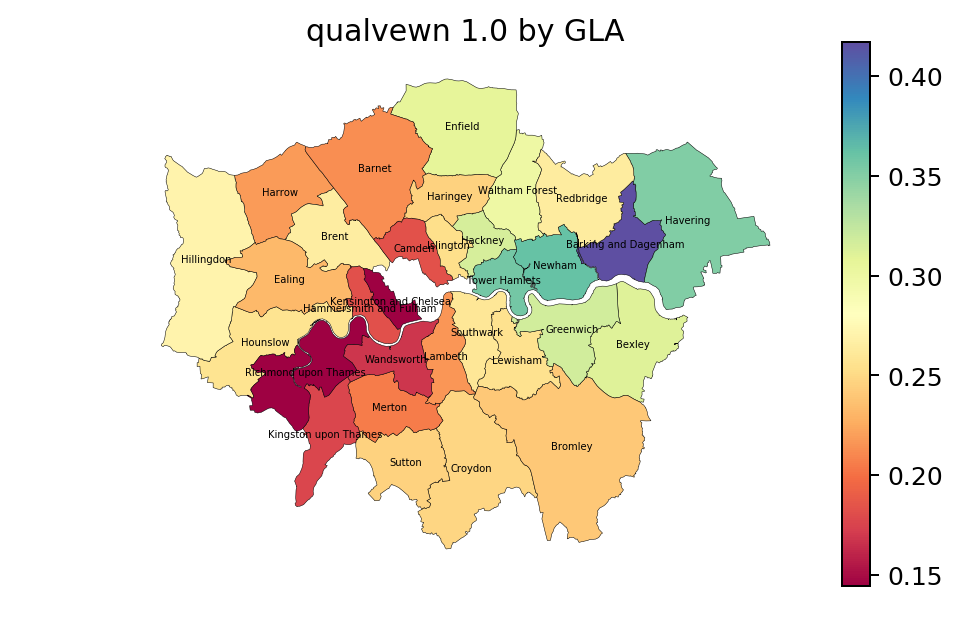

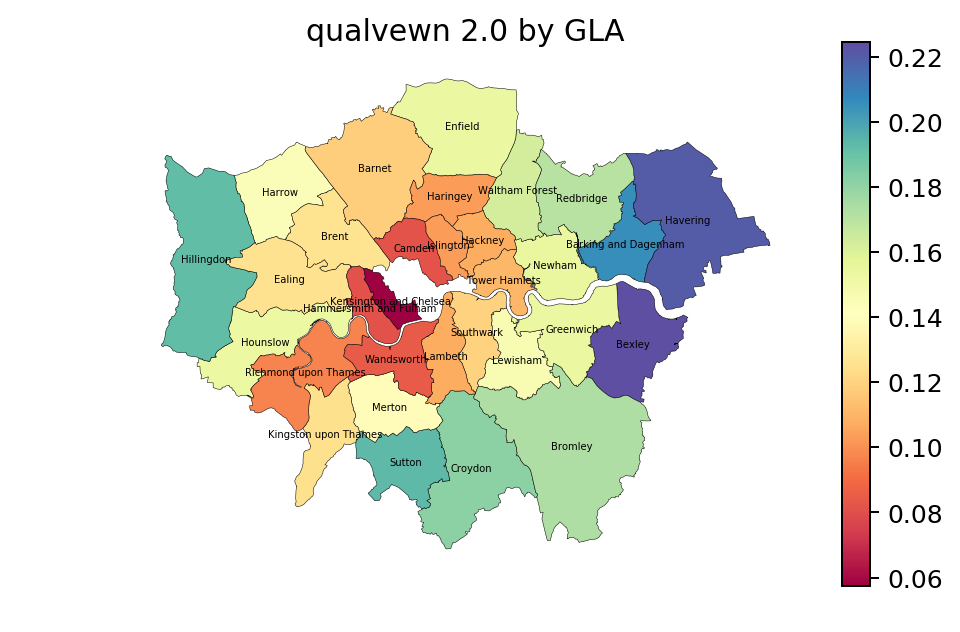

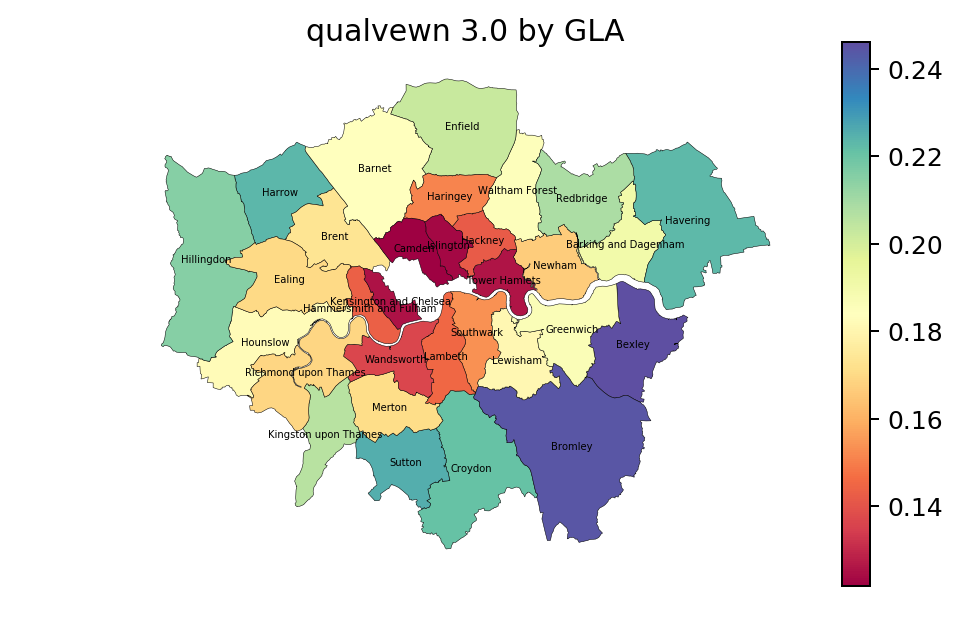

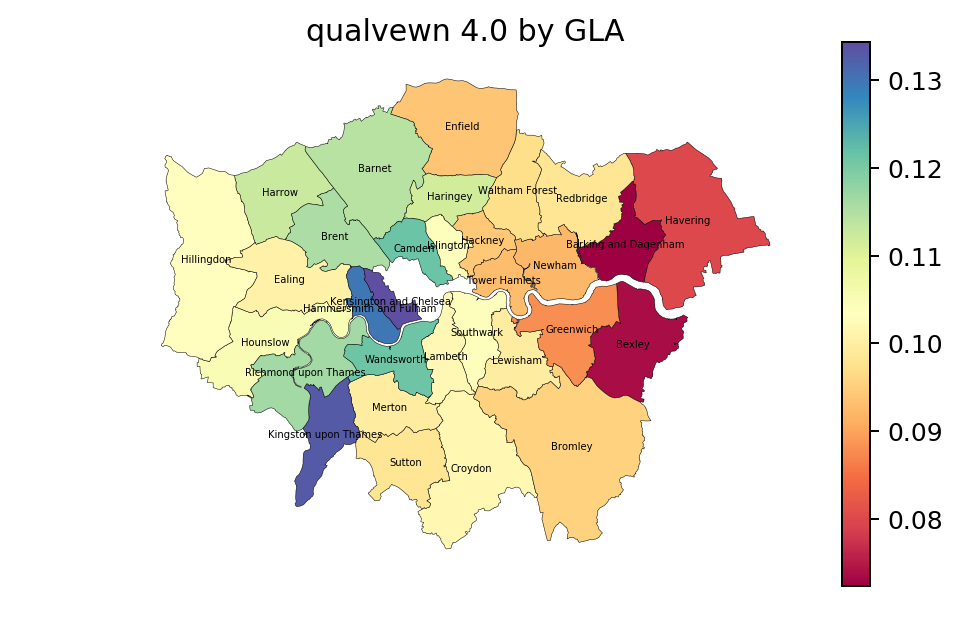

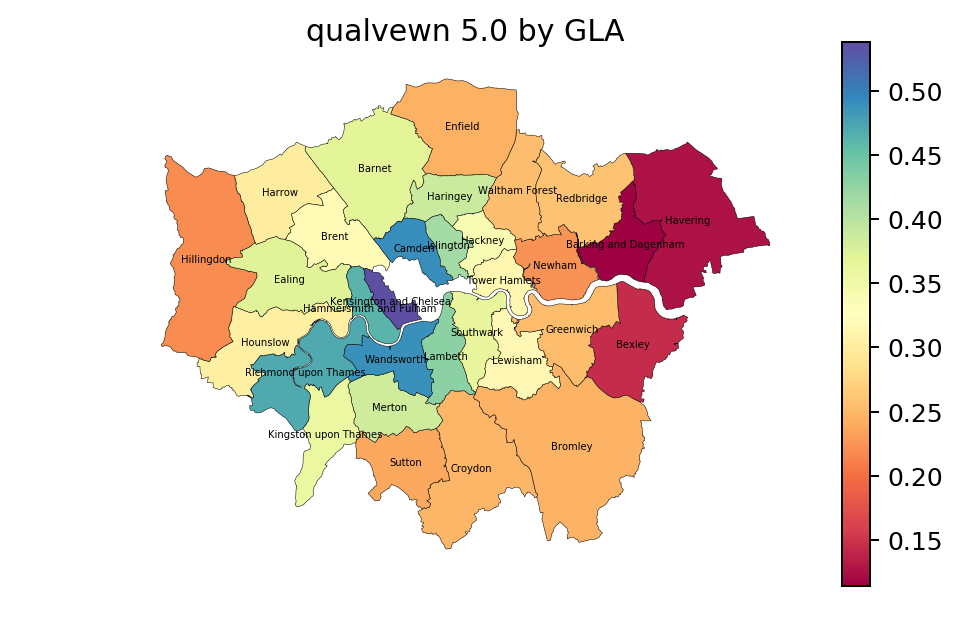

In [547]:
edu_by_la_lon = attribute_by_la(sam_data, 'qualvewn', lon_la2gla_dict, ew_gla_map, ignore=[-9,6], ignore_missing=True, label=True)

	Value = 1	Label = A Professional and B Middle managers
	Value = 2	Label = C1 All other non-manual workers
	Value = 3	Label = C2 All skilled manual workers
	Value = 4	Label = D All semi-skilled and unskilled manual workers
	Value = 5	Label = E On benefit/unemployed

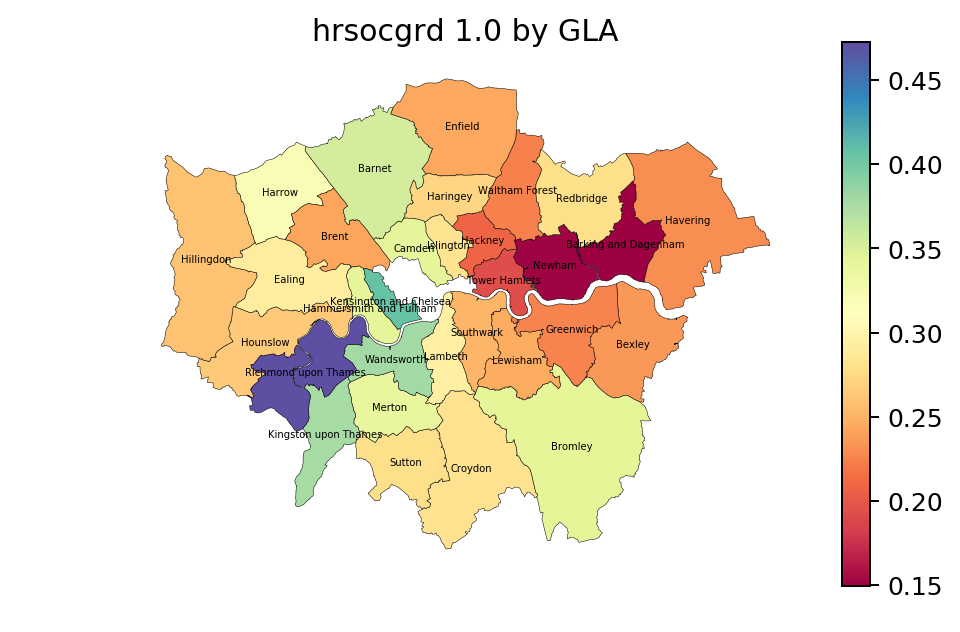

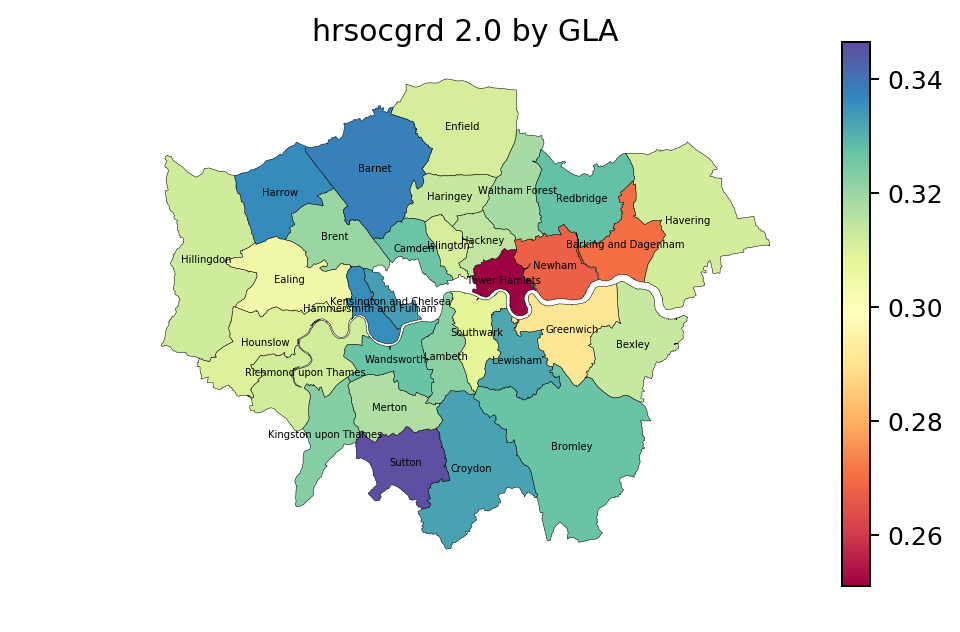

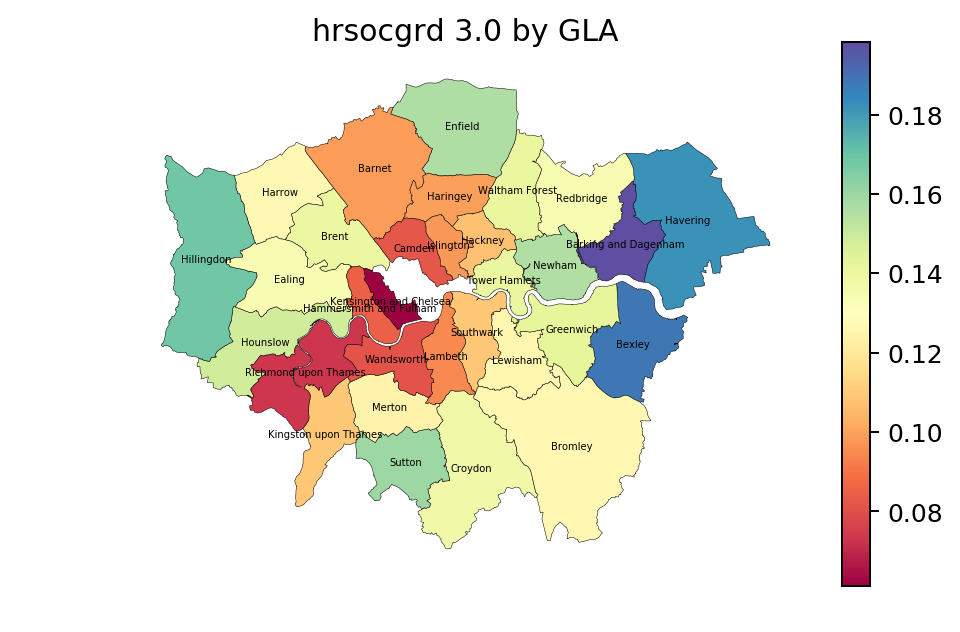

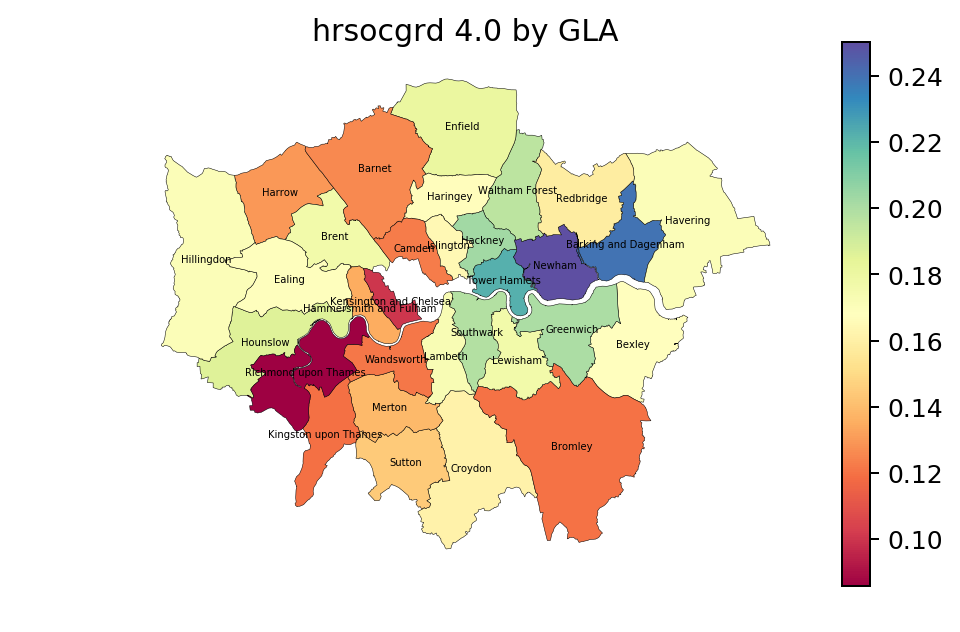

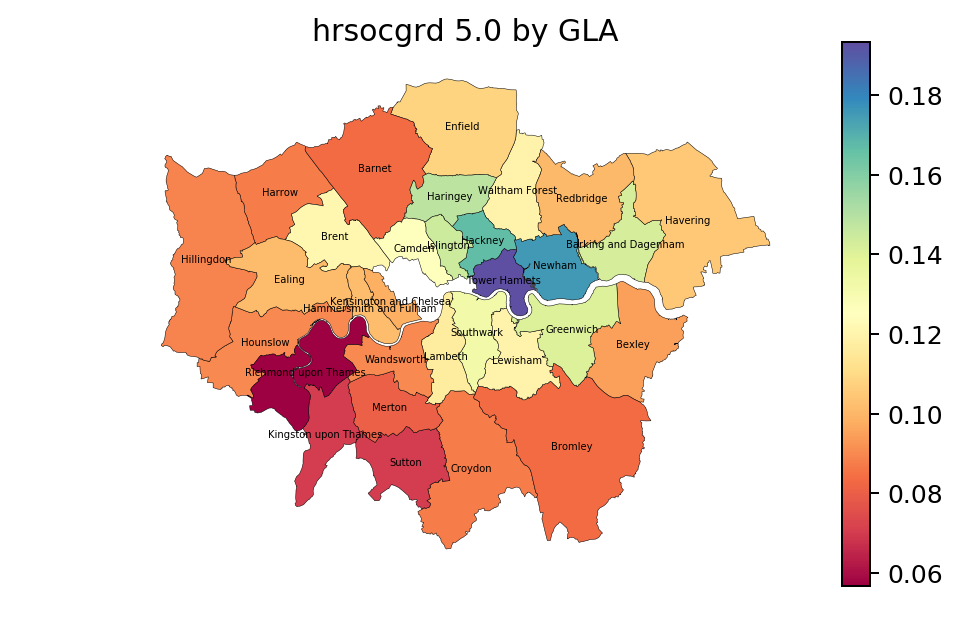

In [549]:
inc_by_la_lon = attribute_by_la(sam_data, 'hrsocgrd', lon_la2gla_dict, ew_gla_map, ignore_missing=True, label=True)

	Value = 1	Label = Christian
	Value = 2	Label = Buddhist
	Value = 3	Label = Hindu
	Value = 4	Label = Jewish
	Value = 5	Label = Muslim
	Value = 6	Label = Sikh
	Value = 7	Label = Other
	Value = 8	Label = No religion

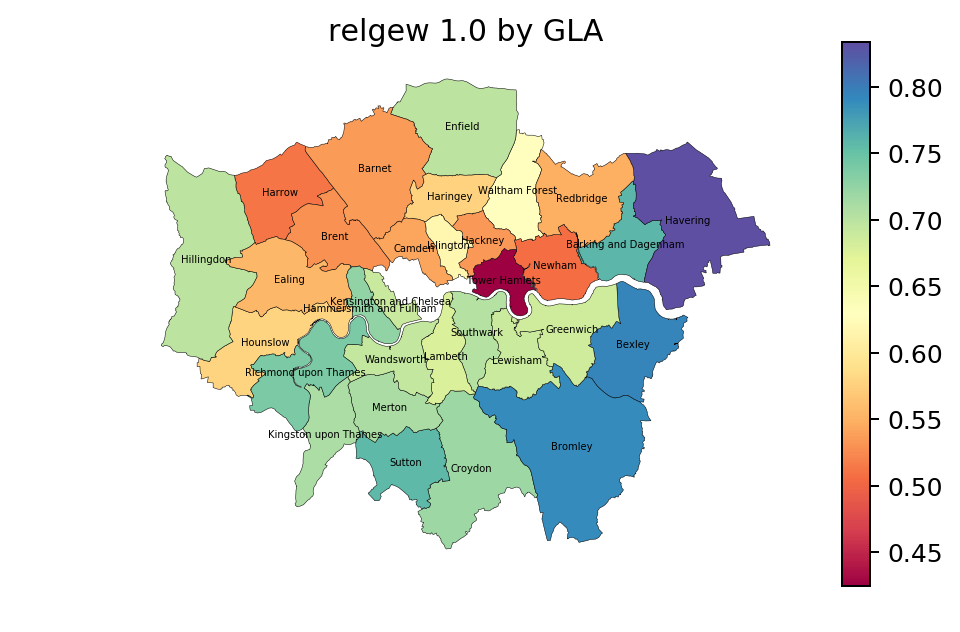

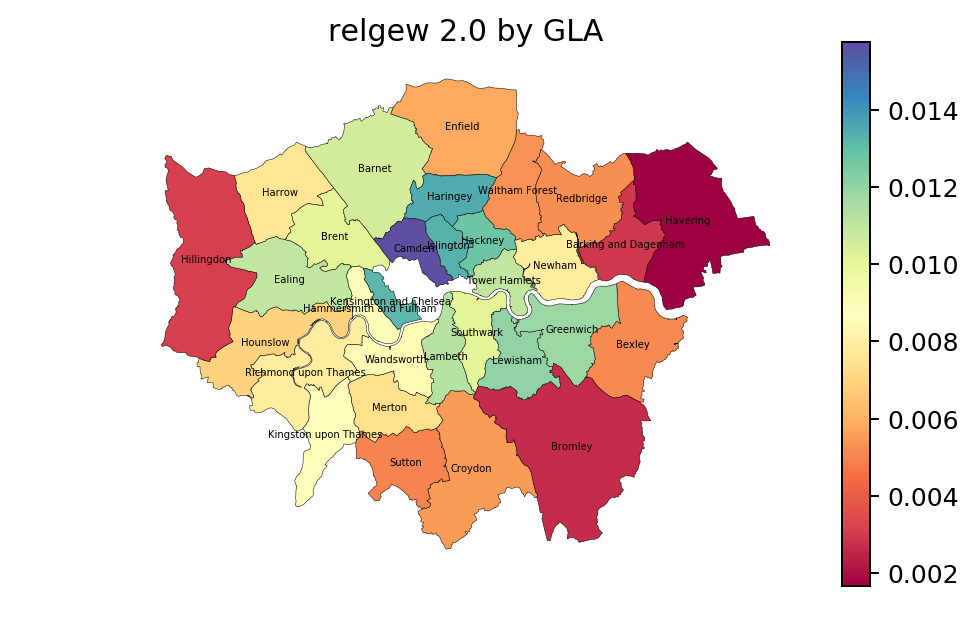

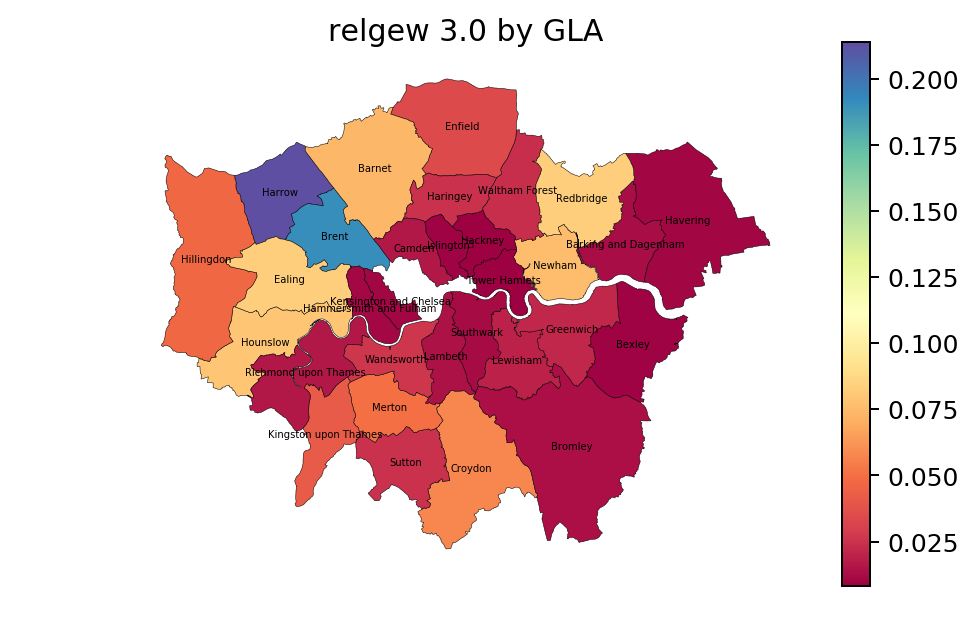

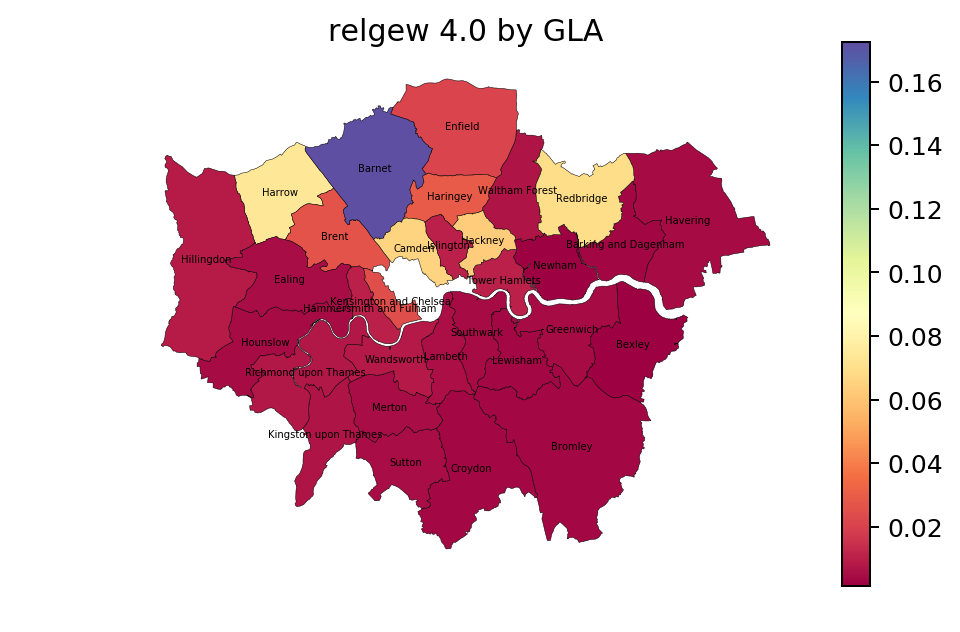

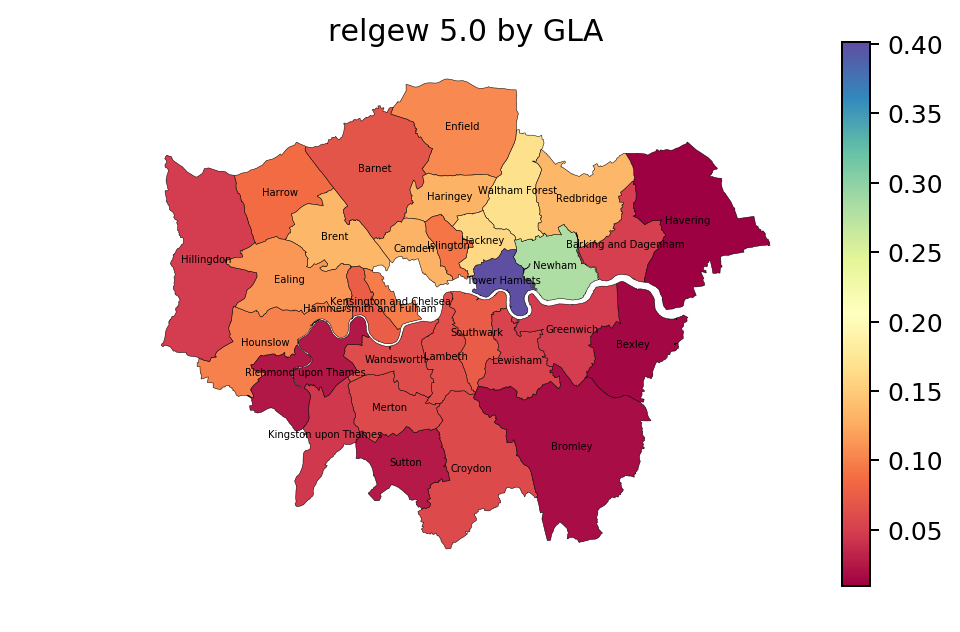

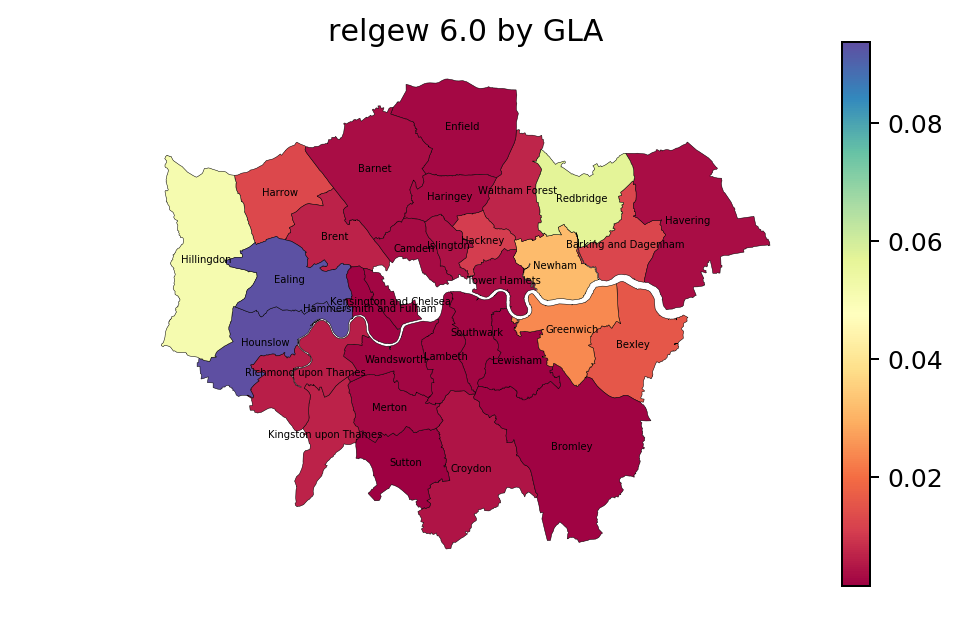

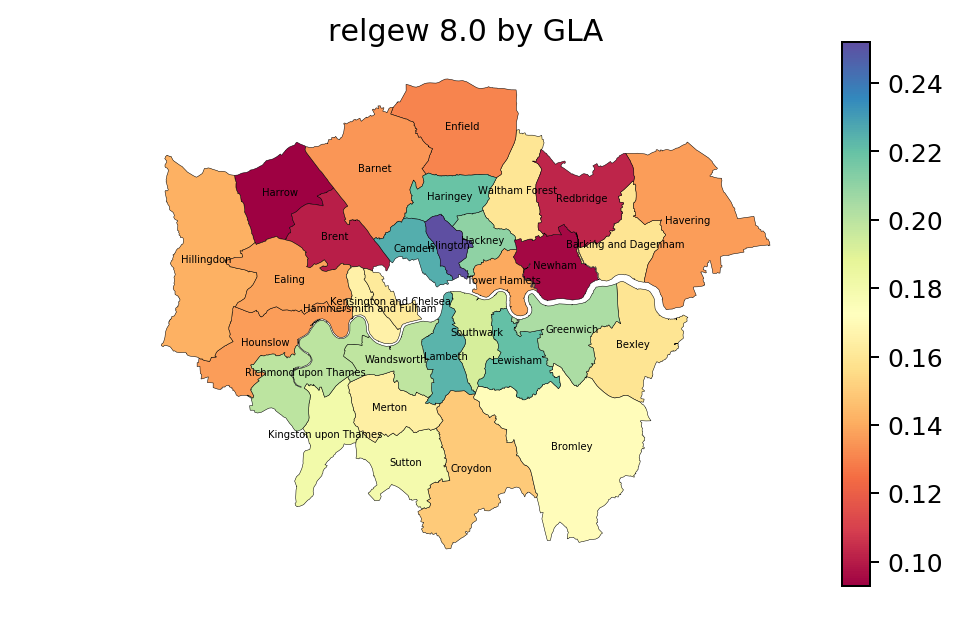

In [551]:
rel_by_la_lon = attribute_by_la(sam_data, 'relgew', lon_la2gla_dict, ew_gla_map, ignore=[-9,7,9], ignore_missing=True, label=True)